In [2]:
from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# Assuming HAM10000 is in archive2.zip
zip_path = '/content/drive/MyDrive/archive2.zip'

if os.path.exists(zip_path):
    print("\nUnzipping ham10000 dataset...")
    os.makedirs('ham10000_data', exist_ok=True)
    os.system(f'unzip -q "{zip_path}" -d ham10000_data/')
    print("Unzipping completed successfully.")
else:
    print(f"\nError: The file was not found at the specified path: {zip_path}")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.

Unzipping ham10000 dataset...


In [3]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# --- Define Parameters ---
base_dir = 'ham10000_data'
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 40

# --- Load Data with Pandas ---
print("Loading metadata from HAM10000_metadata.csv...")
metadata_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))

# --- Create a dictionary of all image paths ---
image_folders = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if 'images' in f]
all_image_paths = {os.path.splitext(f)[0]: os.path.join(folder, f) for folder in image_folders for f in os.listdir(folder)}
metadata_df['image_path'] = metadata_df['image_id'].map(all_image_paths.get)

# --- Convert text labels to numbers (0, 1, 2...) ---
class_names = sorted(metadata_df['dx'].unique())
label_map = {label: i for i, label in enumerate(class_names)}
metadata_df['label'] = metadata_df['dx'].map(label_map.get)

# --- Split Data into Training and Validation ---
train_df, val_df = train_test_split(
    metadata_df, test_size=0.2, random_state=42, stratify=metadata_df['label']
)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# --- Calculate Class Weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_dict = dict(enumerate(class_weights))
print("Calculated Class Weights:", class_weights_dict)

# --- Create tf.data.Dataset pipeline ---
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'], train_df['label']))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['image_path'], val_df['label']))
validation_dataset = validation_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("\nImage-only datasets created successfully.")

Loading metadata from HAM10000_metadata.csv...
Training samples: 8012, Validation samples: 2003
Calculated Class Weights: {0: np.float64(4.368593238822246), 1: np.float64(2.7848453249913105), 2: np.float64(1.3021290427433772), 3: np.float64(12.440993788819876), 4: np.float64(1.2860353130016051), 5: np.float64(0.21338020666879728), 6: np.float64(10.040100250626567)}

Image-only datasets created successfully.


In [4]:
import tensorflow as tf

# Data augmentation layer remains the same
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomBrightness(factor=0.2),
    tf.keras.layers.RandomContrast(factor=0.2)
], name="data_augmentation")

# Load ConvNeXt-Small as the base model
base_model = tf.keras.applications.ConvNeXtSmall(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

# Build the model
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Use the specific preprocessing for ConvNeXt
x = tf.keras.applications.convnext.preprocess_input(inputs)
x = data_augmentation(x)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

198551472/198551472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_small (Functional)     │ (None, 7, 7, 768)      │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         5,383 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,460,071 (188.68 MB)

 Trainable params: 5,383 (21.03 KB)

 Non-trainable params: 49,454,688 (188.65 MB)


Starting model training with ConvNeXt-Small...
Epoch 1/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.2538 - loss: 2.0125 - val_accuracy: 0.3610 - val_loss: 1.5064
Epoch 2/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.4125 - loss: 1.5367 - val_accuracy: 0.4378 - val_loss: 1.3395
Epoch 3/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.4757 - loss: 1.3929 - val_accuracy: 0.4358 - val_loss: 1.3266
Epoch 4/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.5328 - loss: 1.2852 - val_accuracy: 0.5337 - val_loss: 1.1619
Epoch 5/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.5553 - loss: 1.2544 - val_accuracy: 0.4498 - val_loss: 1.3113
Epoch 6/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.5543 - loss: 1.1616 - val_accuracy: 0.5342 - val_loss: 1.1844
Epoch 7/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.5759 - loss: 1.1952 - val_accuracy: 0.4828 - val_loss: 1.2297
Epoch 8/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/s

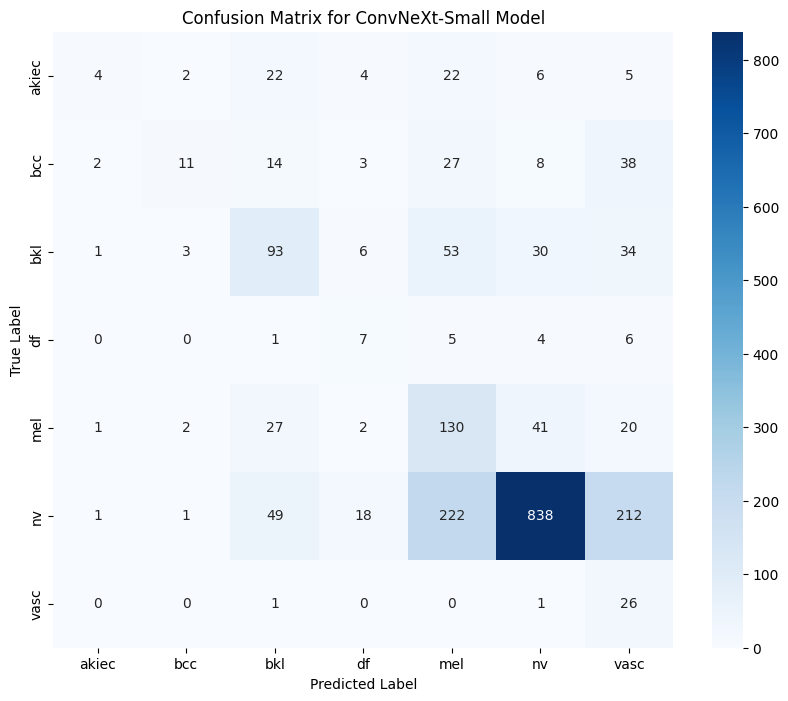

In [5]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Start training
print("\nStarting model training with ConvNeXt-Small...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)
print("\nModel training finished.")

# Enhanced Final Evaluation
print("\nStarting final evaluation...")
loss, accuracy = model.evaluate(validation_dataset)

print("\n" + "="*40)
print("     Final Results on the Validation Set (ConvNeXt-Small)")
print("="*40)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("="*40)

# Detailed Classification Report
print("\n" + "="*50)
print("     Detailed Classification Report")
print("="*50)
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
predictions = model.predict(validation_dataset)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

# Confusion Matrix
print("\n" + "="*50)
print("     Confusion Matrix")
print("="*50)
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for ConvNeXt-Small Model')
plt.show()